In [66]:
import os
import matplotlib.pyplot as plt
import shutil
import pandas as pd
import numpy as np

from nnunetv2.paths import nnUNet_results, nnUNet_raw
import torch
from batchgenerators.utilities.file_and_folder_operations import join
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor
import SimpleITK as sitk

%matplotlib inline

In [2]:
import torch

cuda_version = torch.version.cuda
print("CUDA Version:", cuda_version)


CUDA Version: 11.8


In [3]:
def _flatten(t):
    return [item for sublist in t for item in sublist]


def crop(image, margin, interpolator=sitk.sitkLinear):
    """
    Crops a sitk.Image while retaining correct spacing. Negative margins will lead to zero padding

    Args:
        image:  a sitk.Image
        margin: margins to crop. Single integer or float (percentage crop),
                lists of int/float or nestes lists are supported.
    """
    if isinstance(margin, (list, tuple)):
        assert len(margin) == 3, "expected margin to be of length 3"
    else:
        assert isinstance(margin, (int, float)), "expected margin to be a float value"
        margin = [margin, margin, margin]

    margin = [m if isinstance(m, (tuple, list)) else [m, m] for m in margin]
    old_size = image.GetSize()

    # calculate new origin and new image size
    if all([isinstance(m, float) for m in _flatten(margin)]):
        assert all([m >= 0 and m < 0.5 for m in _flatten(margin)]), "margins must be between 0 and 0.5"
        to_crop = [[int(sz * _m) for _m in m] for sz, m in zip(old_size, margin)]
    elif all([isinstance(m, int) for m in _flatten(margin)]):
        to_crop = margin
    else:
        raise ValueError("Wrong format of margins.")

    new_size = [sz - sum(c) for sz, c in zip(old_size, to_crop)]

    # origin has Index (0,0,0)
    # new origin has Index (to_crop[0][0], to_crop[2][0], to_crop[2][0])
    new_origin = image.TransformIndexToPhysicalPoint([c[0] for c in to_crop])

    # create reference plane to resample image
    ref_image = sitk.Image(new_size, image.GetPixelIDValue())
    ref_image.SetSpacing(image.GetSpacing())
    ref_image.SetOrigin(new_origin)
    ref_image.SetDirection(image.GetDirection())

    return sitk.Resample(image, ref_image, interpolator=interpolator)


# Read and Copy Data

In [36]:
df = pd.read_csv("/home/jaalzate/Tartaglia/Prostate_Tartaglia/New_Dataset/validation_dataset_complete.csv")
path = "/mnt/ceib/datalake/FISABIO_datalake/p0042021"
#groups = df.groupby('subject')


In [37]:
df_t2_axial = df[(df['sequence'] == 'T2w') & (df['orientation']=='ax')]

In [38]:
df_t2_axial

,subject,session,modality,image,orientation,sequence,shape,ProtocolName,SeriesDescription,usable,...,VP,PIR,csPC,F_nacimiento,F_RM,F_TACTO_RECTAL,F_PSA,F_csPC,label_MIDS_session,label_MIDS_subject
1,sub-000063,ses-000063,anat,sub-000063_ses-000063_acq-fse_run-6_bp-p_vp-ax...,ax,T2w,"torch.Size([512, 512, 28])",ax T2,ax T2,True,...,105.698736,3.0,0.0,1947-04-05,2016-07-07,NaN,NaN,14.0,ses-000063,sub-000063
3,sub-000063,ses-000063,anat,sub-000063_ses-000063_acq-fse_run-8_bp-p_vp-ax...,ax,T2w,"torch.Size([512, 512, 28])",ax T2,ax T2,True,...,105.698736,3.0,0.0,1947-04-05,2016-07-07,NaN,NaN,14.0,ses-000063,sub-000063
11,sub-000066,ses-000066,anat,sub-000066_ses-000066_acq-fse_run-8_bp-p_vp-ax...,ax,T2w,"torch.Size([512, 512, 34])",ax T2,ax T2,True,...,NaN,NaN,0.0,1945-03-09,2017-01-27,NaN,-2.0,69.0,ses-000066,sub-000066
22,sub-000184,ses-000184,anat,sub-000184_ses-000184_acq-propeller_run-6_bp-a...,ax,T2w,"torch.Size([512, 512, 55])",Ax T2 PROP. PELVIS,Ax T2 PROP. PELVIS,True,...,46.823400,5.0,1.0,1946-03-12,2018-02-01,NaN,-443.0,162.0,ses-000184,sub-000184
23,sub-000184,ses-000184,anat,sub-000184_ses-000184_acq-propeller_run-3_bp-a...,ax,T2w,"torch.Size([512, 512, 33])",Ax T2 PROPELLER,Ax T2 PROPELLER,True,...,46.823400,5.0,1.0,1946-03-12,2018-02-01,NaN,-443.0,162.0,ses-000184,sub-000184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,sub-000092,ses-000092,anat,sub-000092_ses-000092_acq-fse_run-8_bp-p_vp-ax...,ax,T2w,"torch.Size([512, 512, 28])",ax T2,ax T2,True,...,0.520000,NaN,0.0,1945-10-31,2014-10-02,NaN,-163.0,-90.0,ses-000092,sub-000092
1342,sub-000092,ses-000092,anat,sub-000092_ses-000092_acq-fse_run-13_bp-p_vp-a...,ax,T2w,"torch.Size([512, 512, 28])",ax T2,ax T2,True,...,0.520000,NaN,0.0,1945-10-31,2014-10-02,NaN,-163.0,-90.0,ses-000092,sub-000092
1350,sub-000003,ses-000003,anat,sub-000003_ses-000003_acq-fse_run-10_bp-a_vp-a...,ax,T2w,"torch.Size([512, 512, 26])",ax T2,ax T2,True,...,NaN,NaN,1.0,1945-01-02,2014-03-07,NaN,-42.0,-18.0,ses-000003,sub-000003
1354,sub-000111,ses-000111,anat,sub-000111_ses-000111_acq-fse_run-8_bp-a_vp-ax...,ax,T2w,"torch.Size([512, 512, 28])",ax T2,ax T2,True,...,58.000000,4.0,1.0,1953-01-05,2015-06-24,NaN,NaN,316.0,ses-000111,sub-000111


In [39]:
images_paths = df_t2_axial.copy().apply(lambda x: os.path.join(path, x['subject'], x['session'],'mim-mr','anat', x['image']), axis=1).values

In [40]:
images_paths

array(['/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000063/ses-000063/mim-mr/anat/sub-000063_ses-000063_acq-fse_run-6_bp-p_vp-ax_T2w.nii.gz',
       '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000063/ses-000063/mim-mr/anat/sub-000063_ses-000063_acq-fse_run-8_bp-p_vp-ax_T2w.nii.gz',
       '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000066/ses-000066/mim-mr/anat/sub-000066_ses-000066_acq-fse_run-8_bp-p_vp-ax_T2w.nii.gz',
       '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000184/ses-000184/mim-mr/anat/sub-000184_ses-000184_acq-propeller_run-6_bp-a_vp-ax_T2w.nii.gz',
       '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000184/ses-000184/mim-mr/anat/sub-000184_ses-000184_acq-propeller_run-3_bp-a_vp-ax_T2w.nii.gz',
       '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000184/ses-000184/mim-mr/anat/sub-000184_ses-000184_acq-propeller_run-300_bp-a_vp-ax_T2w.nii.gz',
       '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000179/ses-000179/mim-mr/anat/sub-000179_

In [41]:
# Create temporal folder to save the images in nnUNet format
tmp_folder_imgs = "Prostate_Cancer_TFM/Prostate_Segmentation/sample_images/tmp_images"
tmp_folder_preds = "Prostate_Cancer_TFM/Prostate_Segmentation/sample_images/tmp_predictions"

associated_paths = []

if not os.path.exists(tmp_folder_imgs):
    os.makedirs(tmp_folder_imgs)
if not os.path.exists(tmp_folder_preds):
    os.makedirs(tmp_folder_preds)

# Copying img to model predictions folder.
for i, path in enumerate(images_paths):
    try:
        new_path = os.path.join(tmp_folder_imgs, f"Sample{i}_0000.nii.gz")
        image = sitk.ReadImage(path)

        image = crop(image, margin=[0.2,0.2,0.0])
        associated_paths.append({'original_path': path, 'path_nnunet': new_path})
        sitk.WriteImage(image, new_path)

    except Exception as e:
        print(f"Error in {path}")
        print(e)

associated_paths = pd.DataFrame(associated_paths)

Error in /mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000028/ses-000028/mim-mr/anat/sub-000028_ses-000028_acq-blade_run-9_bp-p_vp-ax_T2w.nii.gz
Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000028/ses-000028/mim-mr/anat/sub-000028_ses-000028_acq-blade_run-9_bp-p_vp-ax_T2w.nii.gz" does not exist.


In [82]:
# instantiate the nnUNetPredictor
predictor = nnUNetPredictor(
    tile_step_size=0.5,
    use_gaussian=True,
    use_mirroring=True,
    perform_everything_on_device=True,
    device=torch.device('cuda', 0),
    verbose=True,
    verbose_preprocessing=True,
    allow_tqdm=True
)

In [83]:
# initializes the network architecture, loads the checkpoint
results_folder = "/nvmescratch/ceib/Prostate/nnUnet/nnUNet_results/Dataset014_ProstateOwn/nnUNetTrainer_100epochs__nnUNetPlans__3d_fullres"
predictor.initialize_from_trained_model_folder(
    results_folder,
    use_folds=(0,1,2,3,4),
    checkpoint_name='checkpoint_best.pth',
)

In [93]:
# Save Segmentations
predictor.predict_from_files([images_list],
                            images_outdir,
                            save_probabilities=False, overwrite=True,
                            num_processes_preprocessing=2, num_processes_segmentation_export=2,
                            folder_with_segs_from_prev_stage=None, num_parts=1, part_id=0)

There are 1 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict
old shape: (36, 308, 308), new_shape: [ 35 257 257], old_spacing: [3.0, 0.3905999958515167, 0.3905999958515167], new_spacing: [3.089737057685852, 0.46875, 0.46875], fn_data: functools.partial(<function resample_data_or_seg_to_shape at 0x7fe3ea11ce50>, is_seg=False, order=3, order_z=0, force_separate_z=None)

Predicting ProstateSample.nii.gz:
perform_everything_on_device: True
Input shape: torch.Size([1, 35, 257, 257])
step_size: 0.5
mirror_axes: (0, 1, 2)
n_steps 8, image size is torch.Size([35, 257, 257]), tile_size [24, 256, 256], tile_step_size 0.5
steps:
[[0, 11], [0, 1], [0, 1]]
move image to device cuda:0
preallocating results arrays on device cuda:0
running prediction


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Input shape: torch.Size([1, 35, 257, 257])
step_size: 0.5
mirror_axes: (0, 1, 2)
n_steps 8, image size is torch.Size([35, 257, 257]), tile_size [24, 256, 256], tile_step_size 0.5
steps:
[[0, 11], [0, 1], [0, 1]]
move image to device cuda:0
preallocating results arrays on device cuda:0
running prediction


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


Input shape: torch.Size([1, 35, 257, 257])
step_size: 0.5
mirror_axes: (0, 1, 2)
n_steps 8, image size is torch.Size([35, 257, 257]), tile_size [24, 256, 256], tile_step_size 0.5
steps:
[[0, 11], [0, 1], [0, 1]]
move image to device cuda:0
preallocating results arrays on device cuda:0
running prediction


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


Input shape: torch.Size([1, 35, 257, 257])
step_size: 0.5
mirror_axes: (0, 1, 2)
n_steps 8, image size is torch.Size([35, 257, 257]), tile_size [24, 256, 256], tile_step_size 0.5
steps:
[[0, 11], [0, 1], [0, 1]]
move image to device cuda:0
preallocating results arrays on device cuda:0
running prediction


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


Input shape: torch.Size([1, 35, 257, 257])
step_size: 0.5
mirror_axes: (0, 1, 2)
n_steps 8, image size is torch.Size([35, 257, 257]), tile_size [24, 256, 256], tile_step_size 0.5
steps:
[[0, 11], [0, 1], [0, 1]]
move image to device cuda:0
preallocating results arrays on device cuda:0
running prediction


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Prediction done
sending off prediction to background worker for resampling and export
done with ProstateSample.nii.gz


[None]

In [50]:
# Predict Array
prediction = predictor.predict_from_files([images_list],
                            None,
                            save_probabilities=True, overwrite=True,
                            num_processes_preprocessing=2, num_processes_segmentation_export=2,
                            folder_with_segs_from_prev_stage=None, num_parts=1, part_id=0)

There are 1 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict

Predicting image of shape torch.Size([1, 23, 341, 339]):
perform_everything_on_device: True


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


sending off prediction to background worker for resampling

Done with image of shape torch.Size([1, 23, 341, 339]):


# Prediction for Bounding Boxes Data

## Organize Dataset

In [248]:
df_bounding_boxes = pd.read_csv("Prostate_Cancer_TFM/Files/Bounding_Boxes/Only_Bounding.csv")
t2_images = df_bounding_boxes[df_bounding_boxes['modality'] == 'T2'].reset_index(drop=True)

In [249]:
t2_images

,subject,session,image,image_associated,bounding_box,SeriesDescription,image_nifti,bval,bvec,modality
0,5586,6040,p0052021/005586/006040/8/DICOM,p0052021/005586/006040/8/DICOM,p0052021/005586/006040/SEG_20240113_205302_952...,ax T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2
1,5586,6040,p0052021/005586/006040/7/DICOM,p0052021/005586/006040/7/DICOM,p0052021/005586/006040/SEG_20240113_205223_953...,Ax T2 ADENOPATIAS,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2
2,5596,6050,p0052021/005596/006050/13001/DICOM,p0052021/005596/006050/13001/DICOM,p0052021/005596/006050/SEG_20240113_211223_114...,AXIAL T2 TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2
3,5700,6173,p0052021/005700/006173/6/DICOM,p0052021/005700/006173/6/DICOM,p0052021/005700/006173/SEG_20240113_211858_507...,AXIAL T2 ALTA RES. (de abajo arriba en próstata),/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2
4,5665,6131,p0052021/005665/006131/6/DICOM,p0052021/005665/006131/6/DICOM,p0052021/005665/006131/SEG_20240115_203626_074...,Ax T2 FSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2
...,...,...,...,...,...,...,...,...,...,...
226,5636,6097,p0052021/005636/006097/501/DICOM,p0052021/005636/006097/501/DICOM,p0052021/005636/006097/SEG_20240113_202733_764...,T2W_TSE_TRA_IQ,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2
227,5613,6070,p0052021/005613/006070/6/DICOM,p0052021/005613/006070/6/DICOM,p0052021/005613/006070/SEG_20240113_203814_089...,AX T2 PROPELLER,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2
228,5646,6108,p0052021/005646/006108/7/DICOM,p0052021/005646/006108/7/DICOM,p0052021/005646/006108/SEG_20240113_210319_135...,Ax T2 FSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2
229,5399,5819,p0052021/005399/005819/701/DICOM,p0052021/005399/005819/701/DICOM,p0052021/005399/005819/SEG_20240109_114231_571...,T2W_TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2


In [250]:
# Create temporal folder to save the images in nnUNet format
tmp_folder_imgs = "Prostate_Cancer_TFM/Prostate_Segmentation/sample_images/tmp_images"
tmp_folder_preds = "Prostate_Cancer_TFM/Prostate_Segmentation/sample_images/tmp_predictions"

associated_paths = []

if not os.path.exists(tmp_folder_imgs):
    os.makedirs(tmp_folder_imgs)
if not os.path.exists(tmp_folder_preds):
    os.makedirs(tmp_folder_preds)

# Copying img to model predictions folder.
for i, path in enumerate(t2_images['image_nifti']):

    new_path = os.path.join(tmp_folder_imgs, f"Sample{i}_0000.nii.gz")
    image = sitk.ReadImage(path)

    image = crop(image, margin=[0.2,0.2,0.0])
    associated_paths.append({'original_path': path, 'path_nnunet': new_path})
    sitk.WriteImage(image, new_path)

associated_paths = pd.DataFrame(associated_paths)

In [251]:
associated_paths

,original_path,path_nnunet
0,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Prostate_Cancer_TFM/Prostate_Segmentation/samp...
1,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Prostate_Cancer_TFM/Prostate_Segmentation/samp...
2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Prostate_Cancer_TFM/Prostate_Segmentation/samp...
3,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Prostate_Cancer_TFM/Prostate_Segmentation/samp...
4,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Prostate_Cancer_TFM/Prostate_Segmentation/samp...
...,...,...
226,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Prostate_Cancer_TFM/Prostate_Segmentation/samp...
227,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Prostate_Cancer_TFM/Prostate_Segmentation/samp...
228,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Prostate_Cancer_TFM/Prostate_Segmentation/samp...
229,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Prostate_Cancer_TFM/Prostate_Segmentation/samp...


## Make Predictions

In [42]:
from nnunetv2.paths import nnUNet_results, nnUNet_raw
import torch
from batchgenerators.utilities.file_and_folder_operations import join
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor

In [43]:
folder_images = "Prostate_Cancer_TFM/Prostate_Segmentation/sample_images/tmp_images/"
pred_outdir = "Prostate_Cancer_TFM/Prostate_Segmentation/sample_images/tmp_predictions"


In [44]:
# instantiate the nnUNetPredictor
predictor = nnUNetPredictor(
    tile_step_size=0.5,
    use_gaussian=True,
    use_mirroring=True,
    perform_everything_on_device=True,
    device=torch.device('cuda', 0),
    verbose=False,
    verbose_preprocessing=False,
    allow_tqdm=True
)

In [45]:
# initializes the network architecture, loads the checkpoint
results_folder = "/nvmescratch/ceib/Prostate/nnUnet/nnUNet_results/Dataset014_ProstateOwn/nnUNetTrainer_100epochs__nnUNetPlans__3d_fullres"
predictor.initialize_from_trained_model_folder(
    results_folder,
    use_folds=(0,1,2,3,4),
    checkpoint_name='checkpoint_best.pth',
)

/clinicfs/userhomes/jaalzate/nnUNet/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "


In [46]:
# Save Segmentations
predictor.predict_from_files(folder_images,
                            pred_outdir,
                            save_probabilities=False, overwrite=False,
                            num_processes_preprocessing=2, num_processes_segmentation_export=2,
                            folder_with_segs_from_prev_stage=None, num_parts=1, part_id=0)

There are 215 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 215 cases that I would like to predict
overwrite was set to False, so I am only working on cases that haven't been predicted yet. That's 215 cases.

Predicting Sample0:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample0

Predicting Sample1:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample1

Predicting Sample10:
perform_everything_on_device: True


100%|██████████| 45/45 [00:15<00:00,  2.98it/s]


sending off prediction to background worker for resampling and export
done with Sample10

Predicting Sample100:
perform_everything_on_device: True


100%|██████████| 54/54 [00:18<00:00,  2.97it/s]


sending off prediction to background worker for resampling and export
done with Sample100

Predicting Sample101:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


sending off prediction to background worker for resampling and export
done with Sample101

Predicting Sample102:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample102

Predicting Sample103:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample103

Predicting Sample104:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample104

Predicting Sample105:
perform_everything_on_device: True


100%|██████████| 36/36 [00:12<00:00,  2.99it/s]


sending off prediction to background worker for resampling and export
done with Sample105

Predicting Sample106:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample106

Predicting Sample107:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample107

Predicting Sample108:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample108

Predicting Sample109:
perform_everything_on_device: True


100%|██████████| 72/72 [00:24<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample109

Predicting Sample11:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample11

Predicting Sample110:
perform_everything_on_device: True


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


sending off prediction to background worker for resampling and export
done with Sample110

Predicting Sample111:
perform_everything_on_device: True


100%|██████████| 72/72 [00:24<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample111

Predicting Sample112:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample112

Predicting Sample113:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample113

Predicting Sample114:
perform_everything_on_device: True


100%|██████████| 54/54 [00:18<00:00,  2.97it/s]


sending off prediction to background worker for resampling and export
done with Sample114

Predicting Sample115:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample115

Predicting Sample116:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample116

Predicting Sample117:
perform_everything_on_device: True


100%|██████████| 72/72 [00:24<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample117

Predicting Sample118:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


sending off prediction to background worker for resampling and export
done with Sample118

Predicting Sample119:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample119

Predicting Sample12:
perform_everything_on_device: True


100%|██████████| 36/36 [00:12<00:00,  2.99it/s]


sending off prediction to background worker for resampling and export
done with Sample12

Predicting Sample120:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample120

Predicting Sample121:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample121

Predicting Sample122:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


sending off prediction to background worker for resampling and export
done with Sample122

Predicting Sample123:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample123

Predicting Sample124:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


sending off prediction to background worker for resampling and export
done with Sample124

Predicting Sample125:
perform_everything_on_device: True


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


sending off prediction to background worker for resampling and export
done with Sample125

Predicting Sample126:
perform_everything_on_device: True


100%|██████████| 72/72 [00:24<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample126

Predicting Sample127:
perform_everything_on_device: True


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


sending off prediction to background worker for resampling and export
done with Sample127

Predicting Sample128:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample128

Predicting Sample129:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample129

Predicting Sample13:
perform_everything_on_device: True


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


sending off prediction to background worker for resampling and export
done with Sample13

Predicting Sample130:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample130

Predicting Sample131:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample131

Predicting Sample132:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample132

Predicting Sample133:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample133

Predicting Sample134:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample134

Predicting Sample135:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample135

Predicting Sample136:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample136

Predicting Sample137:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample137

Predicting Sample138:
perform_everything_on_device: True


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


sending off prediction to background worker for resampling and export
done with Sample138

Predicting Sample139:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample139

Predicting Sample14:
perform_everything_on_device: True


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


sending off prediction to background worker for resampling and export
done with Sample14

Predicting Sample140:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample140

Predicting Sample141:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample141

Predicting Sample142:
perform_everything_on_device: True


100%|██████████| 24/24 [00:07<00:00,  3.01it/s]


sending off prediction to background worker for resampling and export
done with Sample142

Predicting Sample143:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample143

Predicting Sample144:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample144

Predicting Sample145:
perform_everything_on_device: True


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


sending off prediction to background worker for resampling and export
done with Sample145

Predicting Sample146:
perform_everything_on_device: True


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


sending off prediction to background worker for resampling and export
done with Sample146

Predicting Sample147:
perform_everything_on_device: True


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


sending off prediction to background worker for resampling and export
done with Sample147

Predicting Sample148:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


sending off prediction to background worker for resampling and export
done with Sample148

Predicting Sample149:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample149

Predicting Sample15:
perform_everything_on_device: True


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


sending off prediction to background worker for resampling and export
done with Sample15

Predicting Sample150:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


sending off prediction to background worker for resampling and export
done with Sample150

Predicting Sample151:
perform_everything_on_device: True


100%|██████████| 54/54 [00:18<00:00,  2.97it/s]


sending off prediction to background worker for resampling and export
done with Sample151

Predicting Sample152:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample152

Predicting Sample153:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


sending off prediction to background worker for resampling and export
done with Sample153

Predicting Sample154:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


sending off prediction to background worker for resampling and export
done with Sample154

Predicting Sample155:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


sending off prediction to background worker for resampling and export
done with Sample155

Predicting Sample156:
perform_everything_on_device: True


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


sending off prediction to background worker for resampling and export
done with Sample156

Predicting Sample157:
perform_everything_on_device: True


100%|██████████| 200/200 [01:07<00:00,  2.95it/s]


sending off prediction to background worker for resampling and export
done with Sample157

Predicting Sample158:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample158

Predicting Sample159:
perform_everything_on_device: True


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


sending off prediction to background worker for resampling and export
done with Sample159

Predicting Sample16:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample16

Predicting Sample160:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample160

Predicting Sample161:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample161

Predicting Sample162:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample162

Predicting Sample163:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample163

Predicting Sample164:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample164

Predicting Sample165:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample165

Predicting Sample166:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample166

Predicting Sample167:
perform_everything_on_device: True


100%|██████████| 72/72 [00:24<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample167

Predicting Sample168:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample168

Predicting Sample169:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample169

Predicting Sample17:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


sending off prediction to background worker for resampling and export
done with Sample17

Predicting Sample170:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample170

Predicting Sample171:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample171

Predicting Sample172:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample172

Predicting Sample173:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


sending off prediction to background worker for resampling and export
done with Sample173

Predicting Sample174:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample174

Predicting Sample175:
perform_everything_on_device: True


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


sending off prediction to background worker for resampling and export
done with Sample175

Predicting Sample176:
perform_everything_on_device: True


100%|██████████| 128/128 [00:43<00:00,  2.95it/s]


sending off prediction to background worker for resampling and export
done with Sample176

Predicting Sample177:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample177

Predicting Sample178:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample178

Predicting Sample179:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample179

Predicting Sample18:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


sending off prediction to background worker for resampling and export
done with Sample18

Predicting Sample180:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample180

Predicting Sample181:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


sending off prediction to background worker for resampling and export
done with Sample181

Predicting Sample182:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample182

Predicting Sample183:
perform_everything_on_device: True


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


sending off prediction to background worker for resampling and export
done with Sample183

Predicting Sample184:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample184

Predicting Sample185:
perform_everything_on_device: True


100%|██████████| 54/54 [00:18<00:00,  2.97it/s]


sending off prediction to background worker for resampling and export
done with Sample185

Predicting Sample186:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample186

Predicting Sample187:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample187

Predicting Sample188:
perform_everything_on_device: True


100%|██████████| 24/24 [00:07<00:00,  3.01it/s]


sending off prediction to background worker for resampling and export
done with Sample188

Predicting Sample189:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample189

Predicting Sample19:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


sending off prediction to background worker for resampling and export
done with Sample19

Predicting Sample190:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample190

Predicting Sample191:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


sending off prediction to background worker for resampling and export
done with Sample191

Predicting Sample192:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample192

Predicting Sample193:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample193

Predicting Sample194:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample194

Predicting Sample195:
perform_everything_on_device: True


100%|██████████| 81/81 [00:27<00:00,  2.95it/s]


sending off prediction to background worker for resampling and export
done with Sample195

Predicting Sample196:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample196

Predicting Sample197:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample197

Predicting Sample198:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample198

Predicting Sample199:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample199

Predicting Sample2:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample2

Predicting Sample20:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


sending off prediction to background worker for resampling and export
done with Sample20

Predicting Sample200:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


sending off prediction to background worker for resampling and export
done with Sample200

Predicting Sample201:
perform_everything_on_device: True


100%|██████████| 81/81 [00:27<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample201

Predicting Sample202:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample202

Predicting Sample203:
perform_everything_on_device: True


100%|██████████| 72/72 [00:24<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample203

Predicting Sample204:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample204

Predicting Sample205:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample205

Predicting Sample206:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample206

Predicting Sample207:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample207

Predicting Sample208:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample208

Predicting Sample209:
perform_everything_on_device: True


100%|██████████| 45/45 [00:15<00:00,  2.98it/s]


sending off prediction to background worker for resampling and export
done with Sample209

Predicting Sample21:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample21

Predicting Sample210:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample210

Predicting Sample211:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample211

Predicting Sample212:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample212

Predicting Sample213:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample213

Predicting Sample214:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample214

Predicting Sample215:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


sending off prediction to background worker for resampling and export
done with Sample215

Predicting Sample22:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


sending off prediction to background worker for resampling and export
done with Sample22

Predicting Sample23:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample23

Predicting Sample24:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample24

Predicting Sample25:
perform_everything_on_device: True


100%|██████████| 72/72 [00:24<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample25

Predicting Sample26:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample26

Predicting Sample27:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample27

Predicting Sample28:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample28

Predicting Sample29:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


sending off prediction to background worker for resampling and export
done with Sample29

Predicting Sample3:
perform_everything_on_device: True


100%|██████████| 54/54 [00:18<00:00,  2.97it/s]


sending off prediction to background worker for resampling and export
done with Sample3

Predicting Sample30:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


sending off prediction to background worker for resampling and export
done with Sample30

Predicting Sample31:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample31

Predicting Sample32:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample32

Predicting Sample33:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample33

Predicting Sample34:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample34

Predicting Sample35:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample35

Predicting Sample36:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample36

Predicting Sample37:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


sending off prediction to background worker for resampling and export
done with Sample37

Predicting Sample38:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample38

Predicting Sample39:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample39

Predicting Sample4:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample4

Predicting Sample40:
perform_everything_on_device: True


100%|██████████| 36/36 [00:12<00:00,  2.99it/s]


sending off prediction to background worker for resampling and export
done with Sample40

Predicting Sample41:
perform_everything_on_device: True


100%|██████████| 54/54 [00:18<00:00,  2.97it/s]


sending off prediction to background worker for resampling and export
done with Sample41

Predicting Sample42:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample42

Predicting Sample43:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample43

Predicting Sample44:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample44

Predicting Sample45:
perform_everything_on_device: True


100%|██████████| 54/54 [00:18<00:00,  2.97it/s]


sending off prediction to background worker for resampling and export
done with Sample45

Predicting Sample46:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample46

Predicting Sample47:
perform_everything_on_device: True


100%|██████████| 72/72 [00:24<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample47

Predicting Sample48:
perform_everything_on_device: True


100%|██████████| 54/54 [00:18<00:00,  2.98it/s]


sending off prediction to background worker for resampling and export
done with Sample48

Predicting Sample49:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample49

Predicting Sample5:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample5

Predicting Sample50:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample50

Predicting Sample51:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


sending off prediction to background worker for resampling and export
done with Sample51

Predicting Sample52:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample52

Predicting Sample53:
perform_everything_on_device: True


100%|██████████| 81/81 [00:27<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample53

Predicting Sample54:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample54

Predicting Sample55:
perform_everything_on_device: True


100%|██████████| 54/54 [00:18<00:00,  2.97it/s]


sending off prediction to background worker for resampling and export
done with Sample55

Predicting Sample56:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample56

Predicting Sample57:
perform_everything_on_device: True


100%|██████████| 45/45 [00:15<00:00,  2.98it/s]


sending off prediction to background worker for resampling and export
done with Sample57

Predicting Sample58:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample58

Predicting Sample59:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample59

Predicting Sample6:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample6

Predicting Sample60:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample60

Predicting Sample61:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample61

Predicting Sample62:
perform_everything_on_device: True


100%|██████████| 72/72 [00:24<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample62

Predicting Sample63:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample63

Predicting Sample64:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample64

Predicting Sample65:
perform_everything_on_device: True


100%|██████████| 45/45 [00:15<00:00,  2.98it/s]


sending off prediction to background worker for resampling and export
done with Sample65

Predicting Sample66:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample66

Predicting Sample67:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample67

Predicting Sample68:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample68

Predicting Sample69:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample69

Predicting Sample7:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


sending off prediction to background worker for resampling and export
done with Sample7

Predicting Sample70:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample70

Predicting Sample71:
perform_everything_on_device: True


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


sending off prediction to background worker for resampling and export
done with Sample71

Predicting Sample72:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample72

Predicting Sample73:
perform_everything_on_device: True


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


sending off prediction to background worker for resampling and export
done with Sample73

Predicting Sample74:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample74

Predicting Sample75:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample75

Predicting Sample76:
perform_everything_on_device: True


100%|██████████| 81/81 [00:27<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample76

Predicting Sample77:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


sending off prediction to background worker for resampling and export
done with Sample77

Predicting Sample78:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample78

Predicting Sample79:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample79

Predicting Sample8:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample8

Predicting Sample80:
perform_everything_on_device: True


100%|██████████| 128/128 [00:43<00:00,  2.95it/s]


sending off prediction to background worker for resampling and export
done with Sample80

Predicting Sample81:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample81

Predicting Sample82:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample82

Predicting Sample83:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample83

Predicting Sample84:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample84

Predicting Sample85:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample85

Predicting Sample86:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample86

Predicting Sample87:
perform_everything_on_device: True


100%|██████████| 72/72 [00:24<00:00,  2.96it/s]


sending off prediction to background worker for resampling and export
done with Sample87

Predicting Sample88:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample88

Predicting Sample89:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


sending off prediction to background worker for resampling and export
done with Sample89

Predicting Sample9:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample9

Predicting Sample90:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample90

Predicting Sample91:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


sending off prediction to background worker for resampling and export
done with Sample91

Predicting Sample92:
perform_everything_on_device: True


100%|██████████| 54/54 [00:18<00:00,  2.98it/s]


sending off prediction to background worker for resampling and export
done with Sample92

Predicting Sample93:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample93

Predicting Sample95:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample95

Predicting Sample96:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample96

Predicting Sample97:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


sending off prediction to background worker for resampling and export
done with Sample97

Predicting Sample98:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample98

Predicting Sample99:
perform_everything_on_device: True


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


sending off prediction to background worker for resampling and export
done with Sample99


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [282]:
# Move predicted masks to the original folder with the name of the original image
directory = '/nvmescratch/ceib/Prostate/Bounding_Boxes/p0052021/Prostate_Segmentation_AI'
pred_outdir = "Prostate_Cancer_TFM/Prostate_Segmentation/sample_images/tmp_predictions"

associated_paths['Path_Segmentation'] = [os.path.join(directory, *path.split('/')[-5:]) for path in associated_paths['original_path']]


for i, row in associated_paths.iterrows():

    path_prediction = os.path.join(pred_outdir, f"Sample{i}.nii.gz")

    new_path = row['Path_Segmentation']

    # Extract the directory part of the new path
    new_directory = os.path.dirname(new_path)

    # Create the new directory if it doesn't exist
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)
    
    shutil.copy(path_prediction,new_path)

# Restructure paths

## Validation

In [76]:
associated_paths['Path_Segmentation'] = associated_paths['path_nnunet'].apply(lambda x: x.replace('_0000', '').replace('tmp_images', 'tmp_predictions'))

In [77]:
associated_paths['Path_Segmentation'][0]

'Prostate_Cancer_TFM/Prostate_Segmentation/sample_images/tmp_predictions/Sample0.nii.gz'

In [97]:
# Save in derivatives in MIDS format
for i, row in associated_paths.iterrows():
    # Step 1: Load the images
    original_image = sitk.ReadImage(row['original_path'])
    seg_image = sitk.ReadImage(row['Path_Segmentation'])

    # Step 2: Calculate the padding needed
    original_size = original_image.GetSize()
    seg_size = seg_image.GetSize()

    # Calculate the differences in each dimension to know how much to pad
    padding = [max(0, original_size[dim] - seg_size[dim]) for dim in range(3)]

    # Since the Pad function needs before and after padding, we split it equally
    # If an odd number of padding is needed, add the extra padding to 'after'
    before_padding = [p // 2 for p in padding]
    after_padding = [p - bp for p, bp in zip(padding, before_padding)]

    # Step 3: Apply padding if needed
    if any(padding):  # Only pad if there's any dimension that needs it
        padded_seg = sitk.ConstantPad(seg_image, before_padding, after_padding, 0)
    else:
        padded_seg = seg_image  # No padding needed, use the original segmentation image

    # Step 4: Save the padded segmentation image
    save_path = os.path.join(
        '/mnt/ceib/datalake/FISABIO_datalake/p0042021/derivatives/prostate_segmentation',
        '/'.join(row['original_path'].split('/')[-5:]).replace('T2w','mod-T2w_desc-SEG')
    )

    # Create directories if they don't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    sitk.WriteImage(padded_seg, save_path)


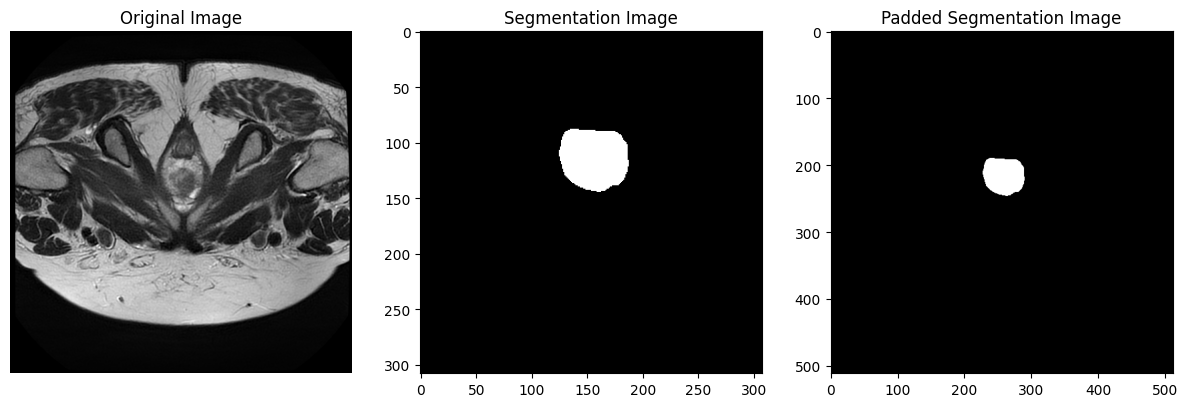

In [86]:
# Plot images to check if the padding was applied correctly
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(sitk.GetArrayFromImage(original_image)[12], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sitk.GetArrayFromImage(seg_image)[12], cmap='gray')
plt.title('Segmentation Image')


plt.subplot(1, 3, 3)
plt.imshow(sitk.GetArrayFromImage(padded_seg)[12], cmap='gray')
plt.title('Padded Segmentation Image')
plt.show()

Text(0.5, 1.0, 'Segmentation Overlay')

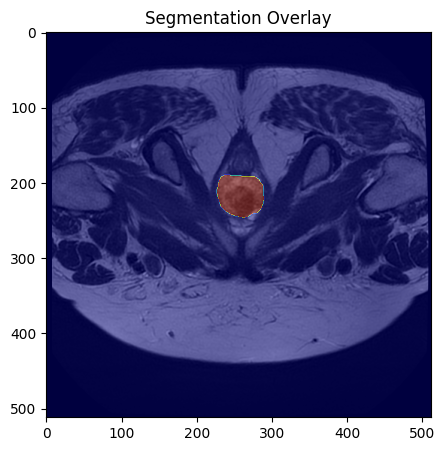

In [87]:
#Overlay the segmentation on the original image
plt.figure(figsize=(15, 5))
plt.imshow(sitk.GetArrayFromImage(original_image)[12], cmap='gray')
plt.imshow(sitk.GetArrayFromImage(padded_seg)[12], cmap='jet', alpha=0.5)
plt.title('Segmentation Overlay')

In [278]:
# Remove temporal folders
shutil.rmtree(tmp_folder_imgs)
shutil.rmtree(tmp_folder_preds)



In [283]:
# Associate df_bounding_boxes with the predictions

df_merged = pd.merge(df_bounding_boxes, associated_paths, left_on='image_nifti', right_on='original_path', how='left')
df_merged = df_merged.drop(columns=['original_path', 'path_nnunet'])


In [284]:
df_merged

,subject,session,image,image_associated,bounding_box,SeriesDescription,image_nifti,bval,bvec,modality,Path_Segmentation
0,5586,6040,p0052021/005586/006040/8/DICOM,p0052021/005586/006040/8/DICOM,p0052021/005586/006040/SEG_20240113_205302_952...,ax T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
1,5586,6040,p0052021/005586/006040/7/DICOM,p0052021/005586/006040/7/DICOM,p0052021/005586/006040/SEG_20240113_205223_953...,Ax T2 ADENOPATIAS,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
2,5596,6050,p0052021/005596/006050/13001/DICOM,p0052021/005596/006050/13001/DICOM,p0052021/005596/006050/SEG_20240113_211223_114...,AXIAL T2 TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
3,5700,6173,p0052021/005700/006173/9/DICOM,p0052021/005700/006173/9/DICOM,p0052021/005700/006173/SEG_20240113_211959_757...,AXIAL DW 1500 PROSTATA,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,DWI,NaN
4,5700,6173,p0052021/005700/006173/7/DICOM,p0052021/005700/006173/7/DICOM,p0052021/005700/006173/SEG_20240113_211927_274...,AXIAL DW 1000 PROSTATA,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,DWI,NaN
...,...,...,...,...,...,...,...,...,...,...,...
530,5646,6108,p0052021/005646/006108/4/DICOM,p0052021/005646/006108/4/DICOM,p0052021/005646/006108/SEG_20240113_210039_451...,AXI PELVIS DWI B50-800,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,DWI,NaN
531,5646,6108,p0052021/005646/006108/1050/DICOM,p0052021/005646/006108/1050/DICOM,p0052021/005646/006108/SEG_20240113_205921_383...,ADC (10^-6 mm²/s):Nov 26 2019 16-59-11 CET,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,ADC,NaN
532,5646,6108,p0052021/005646/006108/1000/DICOM,p0052021/005646/006108/1000/DICOM,p0052021/005646/006108/SEG_20240113_205854_334...,DW_Synthetic: Ax FOCUS B-50-800 Synthetic B-2000,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,DWI,NaN
533,5399,5819,p0052021/005399/005819/701/DICOM,p0052021/005399/005819/701/DICOM,p0052021/005399/005819/SEG_20240109_114231_571...,T2W_TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...


In [285]:
df_merged.to_csv("Prostate_Cancer_TFM/Files/Bounding_Boxes/Only_Bounding.csv", index=False)

# Prediction for Validation Data

In [25]:
import os
import json
import pandas as pd

In [26]:

# Creating  tables
path = "/mnt/ceib/datalake/FISABIO_datalake/p0042021"
derivatives_path = "/mnt/ceib/datalake/FISABIO_datalake/p0042021/derivatives/creating_adc"
t2_list = []
adc_list = []
dwi_list = []

# Creating a list of all the files in the directory starting with sub-*
subjects = [f for f in os.listdir(path) if f.startswith("sub-")]
derivatives_subs = [f for f in os.listdir(derivatives_path) if f.startswith("sub-")]

for sub in subjects:
    derivative_sessions=None
    if sub in derivatives_subs:
        derivative_sessions = [f for f in os.listdir(os.path.join(derivatives_path, sub)) if f.startswith("ses-")]
    sessions = [f for f in os.listdir(os.path.join(path, sub)) if f.startswith("ses-")]
    for ses in sessions:
        # Check if the anat and dwi paths exist
        anat_path = os.path.join(path, sub, ses,'mim-mr','anat')
        dwi_path = os.path.join(path, sub, ses,'mim-mr','dwi')

        if os.path.exists(anat_path):
            images_anat = [f for f in os.listdir(anat_path) if f.endswith(".nii.gz")]
            for img in images_anat:
                if 'T2w' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','anat', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'T2w'}
                    img_dict.update(data)
                    t2_list.append(img_dict)
        if os.path.exists(dwi_path):
            images_dwi = [f for f in os.listdir(dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                if 'bvalue' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'dwi'}
                    img_dict.update(data)
                    dwi_list.append(img_dict)
                elif 'adc' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'adc'}
                    img_dict.update(data)
                    adc_list.append(img_dict)
    if derivative_sessions:
        for ses in derivative_sessions:
            der_dwi_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi')
            images_dwi = [f for f in os.listdir(der_dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                json_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                with open(json_path) as f:
                    data = json.load(f)
                #Add json data to the dict image
                img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'adc'}
                img_dict.update(data)
                adc_list.append(img_dict)


t2w_df = pd.DataFrame(t2_list)
dwi_df = pd.DataFrame(dwi_list)
adc_df = pd.DataFrame(adc_list)

In [27]:
t2w_df

,subject,session,image,modality,AccessionNumber,AcquisitionDateTime,AcquisitionMatrixPE,AcquisitionNumber,AcquisitionTime,AngioFlag,...,WindowCenter,WindowWidth,BodyPartExamined,RawImage,PhaseEncodingSteps,PartialFourier,SequenceName,SliceTiming,InversionTime,Contrast/BolusRoute
0,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-3_bp-p_vp-sa...,T2w,000063,2016-07-07T14:52:47.000000,256,1,14:52:47.000000,N,...,985,1971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-6_bp-p_vp-ax...,T2w,000063,2016-07-07T15:02:32.000000,224,1,15:02:32.000000,N,...,888,1776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-8_bp-p_vp-ax...,T2w,000063,2016-07-07T15:13:34.000000,224,1,15:13:34.000000,N,...,1286,2573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-000066,ses-000066,sub-000066_ses-000066_acq-fse_run-5_bp-p_vp-sa...,T2w,000066,2017-01-27T15:33:36.000000,256,1,15:33:36.000000,N,...,914,1829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-000066,ses-000066,sub-000066_ses-000066_acq-fse_run-8_bp-p_vp-ax...,T2w,000066,2017-01-27T15:44:32.000000,224,1,15:44:32.000000,N,...,960,1921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,sub-000003,ses-000003,sub-000003_ses-000003_acq-fse_run-8_bp-a_vp-sa...,T2w,000003,2014-03-07T08:27:39.000000,256,1,08:27:39.000000,N,...,660,1320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489,sub-000111,ses-000111,sub-000111_ses-000111_acq-fse_run-8_bp-a_vp-ax...,T2w,000111,2015-06-24T19:55:41.000000,224,1,19:55:41.000000,N,...,865,1731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490,sub-000111,ses-000111,sub-000111_ses-000111_acq-fse_run-5_bp-a_vp-sa...,T2w,000111,2015-06-24T19:43:50.000000,256,1,19:43:50.000000,N,...,1132,2264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,sub-000120,ses-000120,sub-000120_ses-000120_acq-fse_run-6_bp-a_vp-sa...,T2w,000120,2014-09-24T08:12:51.000000,256,1,08:12:51.000000,N,...,710,1421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
images_paths = t2w_df.copy().apply(lambda x: os.path.join(path, x['subject'], x['session'],'mim-mr','anat', x['image']), axis=1)

# Divide into axial, coronal and sagital images
data_list = []
for path in images_paths.values:
    files = {}

    files['subject'] = path.split('/')[-5]
    files['session'] = path.split('/')[-4]
    
    image_name = path.split('/')[-1]
    if 'sag' in image_name:
        files['sagital'] = path
    elif 'cor' in image_name:
        files['coronal'] = path
    elif 'ax' in image_name:
        files['axial'] = path
    data_list.append(files)

t2w_df = pd.DataFrame(data_list)

In [29]:
t2w_df

,subject,session,sagital,axial,coronal
0,sub-000063,ses-000063,/mnt/ceib/datalake/FISABIO_datalake/p0042021/s...,NaN,NaN
1,sub-000063,ses-000063,NaN,/mnt/ceib/datalake/FISABIO_datalake/p0042021/s...,NaN
2,sub-000063,ses-000063,NaN,/mnt/ceib/datalake/FISABIO_datalake/p0042021/s...,NaN
3,sub-000066,ses-000066,/mnt/ceib/datalake/FISABIO_datalake/p0042021/s...,NaN,NaN
4,sub-000066,ses-000066,NaN,/mnt/ceib/datalake/FISABIO_datalake/p0042021/s...,NaN
...,...,...,...,...,...
488,sub-000003,ses-000003,/mnt/ceib/datalake/FISABIO_datalake/p0042021/s...,NaN,NaN
489,sub-000111,ses-000111,NaN,/mnt/ceib/datalake/FISABIO_datalake/p0042021/s...,NaN
490,sub-000111,ses-000111,/mnt/ceib/datalake/FISABIO_datalake/p0042021/s...,NaN,NaN
491,sub-000120,ses-000120,/mnt/ceib/datalake/FISABIO_datalake/p0042021/s...,NaN,NaN


In [30]:
t2w_df_axial = t2w_df.dropna(subset=['axial'])

In [32]:
t2w_df_axial.subject.unique()

array(['sub-000063', 'sub-000066', 'sub-000184', 'sub-000179',
       'sub-000108', 'sub-000176', 'sub-000103', 'sub-000155',
       'sub-000078', 'sub-000015', 'sub-000042', 'sub-000035',
       'sub-000004', 'sub-000081', 'sub-000026', 'sub-000034',
       'sub-000175', 'sub-000071', 'sub-000018', 'sub-000024',
       'sub-000048', 'sub-000084', 'sub-000127', 'sub-000096',
       'sub-000032', 'sub-000146', 'sub-000168', 'sub-000082',
       'sub-000138', 'sub-000130', 'sub-000160', 'sub-000021',
       'sub-000115', 'sub-000023', 'sub-000062', 'sub-000159',
       'sub-000151', 'sub-000123', 'sub-000093', 'sub-000097',
       'sub-000134', 'sub-000090', 'sub-000121', 'sub-000132',
       'sub-000005', 'sub-000016', 'sub-000033', 'sub-000065',
       'sub-000136', 'sub-000044', 'sub-000142', 'sub-000041',
       'sub-000087', 'sub-000150', 'sub-000085', 'sub-000135',
       'sub-000006', 'sub-000112', 'sub-000030', 'sub-000110',
       'sub-000057', 'sub-000043', 'sub-000047', 'sub-0

In [ ]:
# Create temporal folder to save the images in nnUNet format
tmp_folder_imgs = "Prostate_Cancer_TFM/Prostate_Segmentation/sample_images/tmp_images"
tmp_folder_preds = "Prostate_Cancer_TFM/Prostate_Segmentation/sample_images/tmp_predictions"

associated_paths = []

if not os.path.exists(tmp_folder_imgs):
    os.makedirs(tmp_folder_imgs)
if not os.path.exists(tmp_folder_preds):
    os.makedirs(tmp_folder_preds)

# Copying img to model predictions folder.
for i, path in enumerate(t2w_df_axial['axial']):

    new_path = os.path.join(tmp_folder_imgs, f"Sample{i}_0000.nii.gz")
    image = sitk.ReadImage(path)

    image = crop(image, margin=[0.2,0.2,0.0])
    associated_paths.append({'original_path': path, 'path_nnunet': new_path})
    sitk.WriteImage(image, new_path)

associated_paths = pd.DataFrame(associated_paths)

In [24]:
t2w_df_axial['subject'].unique().shape

(148,)